# Load Packages

In [1]:
## data manipulation
import pandas as pd 
import numpy as np

## ML
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import xgboost as xgb

## visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
## env vars
RFC_METRIC = 'gini' ## RandFore metric
NUM_ESTIMATORS = 100 ## RandFore number of estimators
NO_JOBS = 4 ## RandFore parallel jobs

VALID_SIZE = 0.20
TEST_SIZE = 0.20

NUM_KFOLDS = 5 ## for cross-val

RND_STATE = 2023

MAX_ROUNDS = 1000 ## for XGB
EARLY_STOP = 50 ## for XGB
OPT_ROUNDS = 1000 ## for XGB

VERBOSE_EVAL = 50 ## for XGB

PATH = "../data/" ## data path

## Read data

In [3]:
df = pd.read_csv(PATH+"creditcard.csv")

In [4]:
## check data
print(df.shape)
display(df.head(5))

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Explore data

As input variables denoted as `V#` are pca results there is no major way to interpret the units and stuff. Check only on `[Time, Ammount]`

In [5]:
df[["Time", "Amount"]].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [6]:
## missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## target var
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
## transactions in time by label
class_0 = df.loc[df['Class']==0]['Time']
class_1 = df.loc[df['Class']==1]['Time']

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(
    hist_data, 
    group_labels, 
    show_hist=False,
    show_rug=False
)
fig['layout'].update(title='Credit Card Transactions Time Density Plot')
iplot(fig, filename='dist_only')

Explore a little bit the distribution on `Fraud` transactions cause it seems that there is a distribution more clear

In [9]:
## assuming Time is in seconds, create an hour var
df['Hour'] = df['Time'].apply(lambda x: np.floor(x/3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df_tmp = pd.DataFrame(tmp)
df_tmp.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df_tmp.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


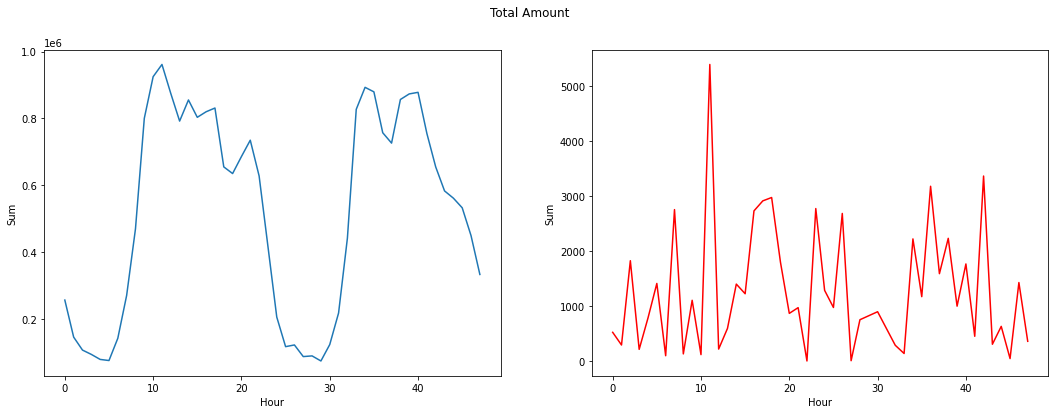

In [10]:
## plot differences in amounts of Fraud and non-Fraud ammounts
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Sum', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Sum', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Total Amount')
plt.show()

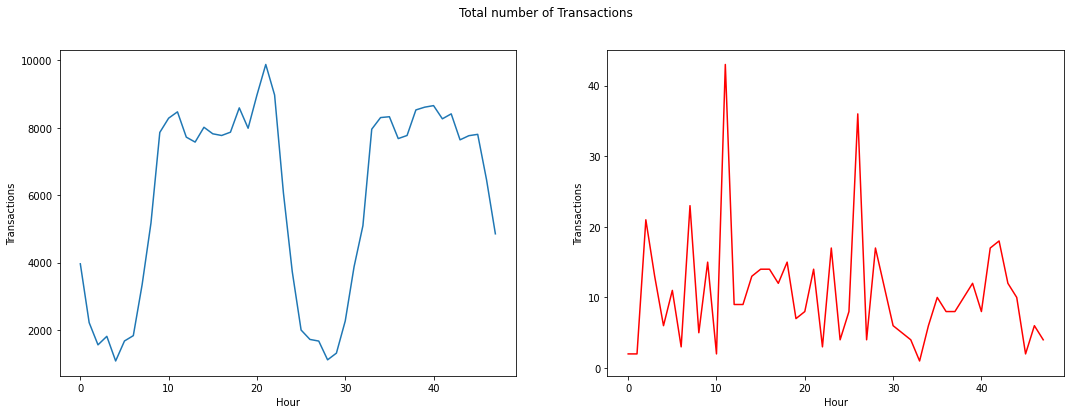

In [11]:
## plot number of transactions
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Transactions', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Transactions', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Total number of Transactions')
plt.show()

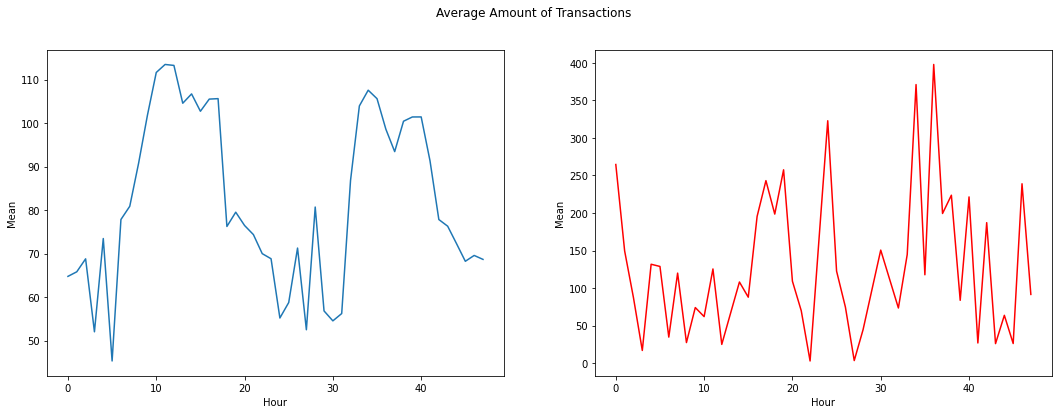

In [12]:
## plot average transations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Mean', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Mean', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Average Amount of Transactions')
plt.show()

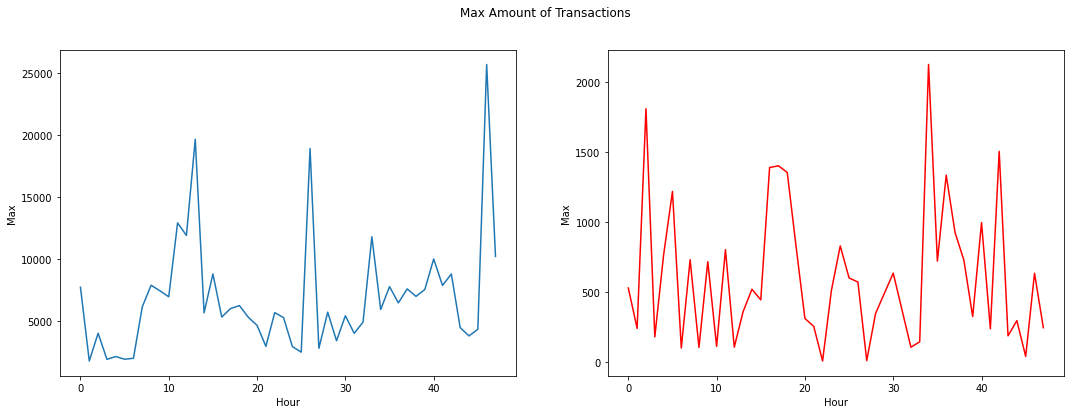

In [13]:
## plot max amounts transations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Max', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Max', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Max Amount of Transactions')
plt.show()

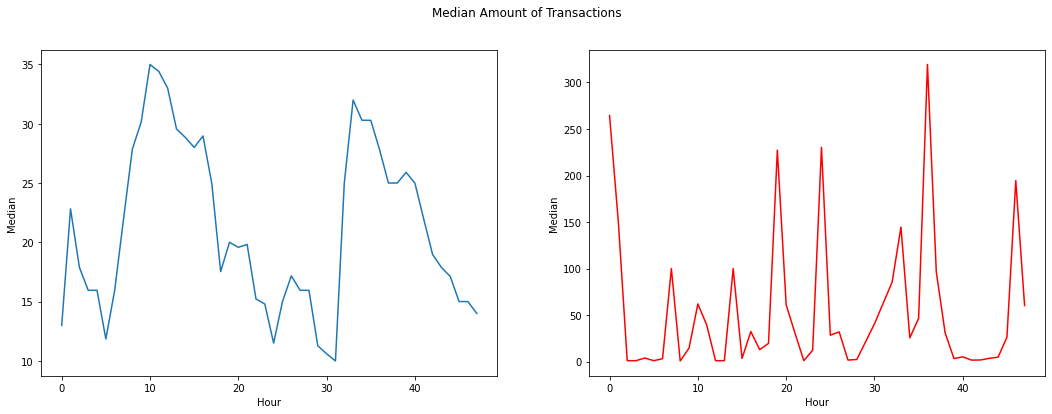

In [14]:
## plot median amounts transations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Median', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Median', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Median Amount of Transactions')
plt.show()

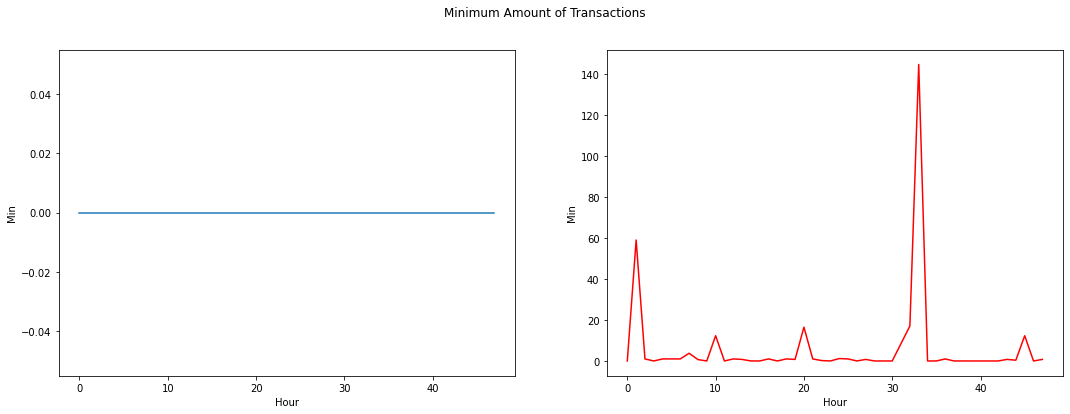

In [15]:
## plot minimum amounts transations
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
s = sns.lineplot(ax=ax1, x='Hour', y='Min', data=df_tmp.loc[df_tmp['Class']==0])
s = sns.lineplot(ax=ax2, x='Hour', y='Min', data=df_tmp.loc[df_tmp['Class']==1], color='red')
plt.suptitle('Minimum Amount of Transactions')
plt.show()

Keys start appearing here looking at the minimum ammount of transactions. It seems that there are some stations

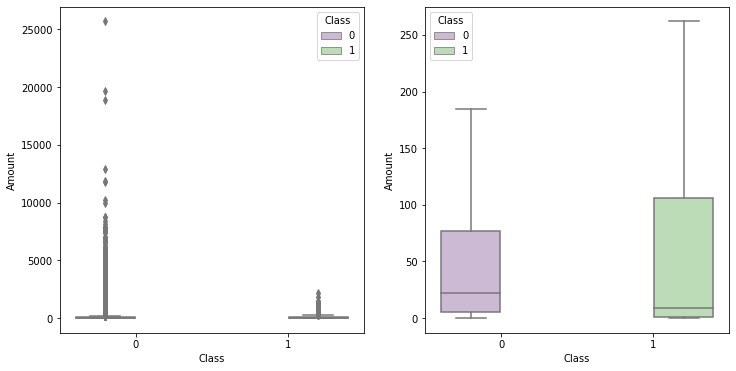

In [16]:
## plot transactions ammount box-plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
s = sns.boxplot(ax=ax1, x='Class', y='Amount', hue='Class', data=df, palette='PRGn', showfliers=True)
s = sns.boxplot(ax=ax2, x='Class', y='Amount', hue='Class', data=df, palette='PRGn', showfliers=False)
plt.show()

Fraud transactions could not pass a certain threshold cause fraudsters knows that transactions that are greater than some amount are needed to be confirm. But in Q3 are greater than non-fraudulent ones.</br>
So it seems that fraud transactions are more likely to be between Q2 and Q3.

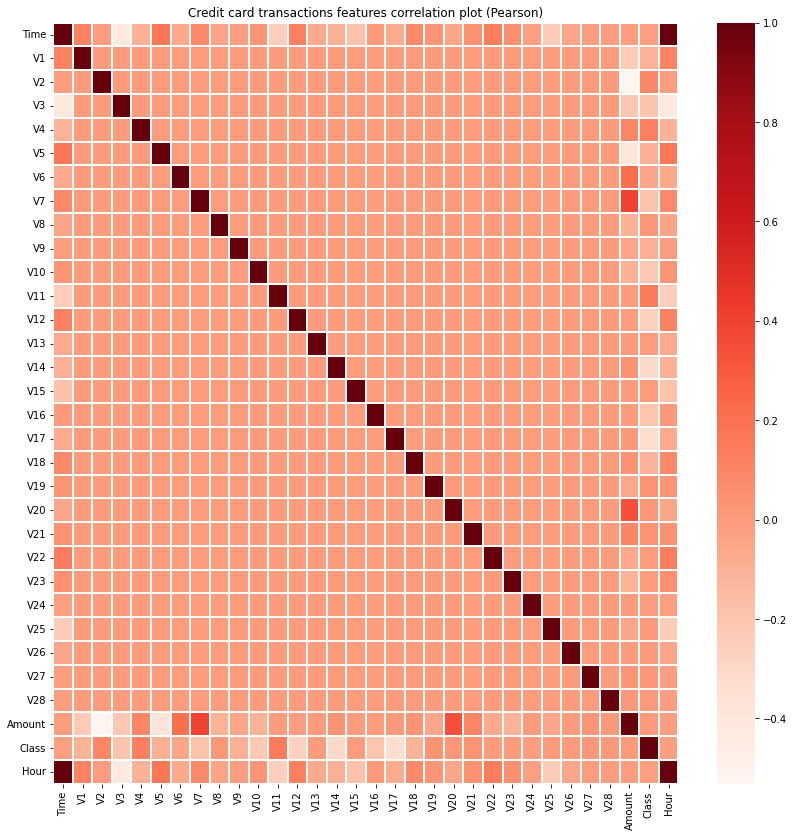

In [17]:
## Features correlation
plt.figure(figsize=(14,14))
plt.title('Credit card transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, cmap='Reds')
plt.show()

Explore deeper positive correlated {Amount;V7} and {Amount;V20}</br>
* `lmplot` plots regression models across conditional subsets of a dataset 

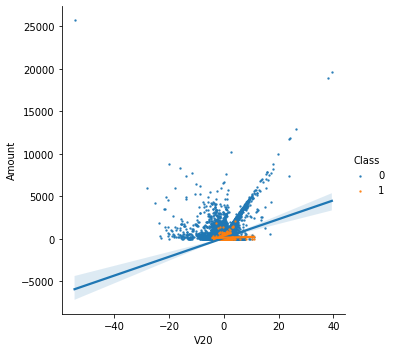

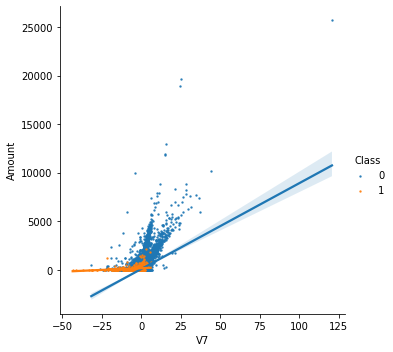

In [18]:
s = sns.lmplot(x='V20', y='Amount', data=df, hue='Class', fit_reg=True, scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount', data=df, hue='Class', fit_reg=True, scatter_kws={'s':2})
plt.show()

There are positive slopes in both features, related with transaction amounts, so we can confirm the positive correlation between these features and amounts

Explore deeper negative correlated {Amount;V2} and {Amount;V5}

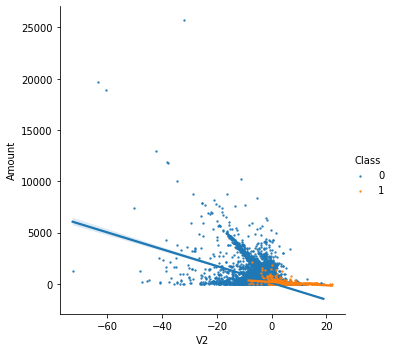

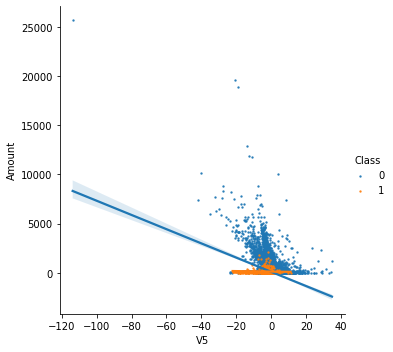

In [19]:
s = sns.lmplot(x='V2', y='Amount', data=df, hue='Class', fit_reg=True, scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount', data=df, hue='Class', fit_reg=True, scatter_kws={'s':2})
plt.show()

Interpretation is similar as above, now slopes are negative. But is pretty intuitive.

## Predictive models

In [20]:
target = 'Class'
predictors = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Amount'
]

In [21]:
## split data
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RND_STATE, shuffle=True)
train_df, valid_df = train_test_split(df, test_size=VALID_SIZE, random_state=RND_STATE, shuffle=True)

### Baseline

In [22]:
clf = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RND_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2023, verbose=False)

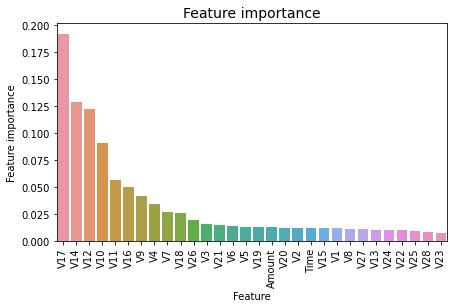

In [23]:
## feature importances
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)
plt.figure(figsize=(7,4))
plt.title('Feature importance', fontsize=14)
s = sns.barplot(x='Feature', y='Feature importance', data=tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

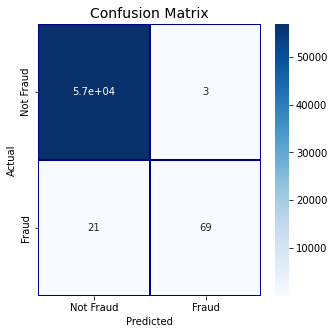

In [24]:
## confusion matrix
preds = clf.predict(valid_df[predictors])
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(
    cm,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot=True,
    ax=ax1,
    linewidths=.2,
    linecolor='Darkblue',
    cmap='Blues'
)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Goal is primally to minize **Type I errors** and **Type II errors**
* **Type I errors:** [False positives] accept a fraud when it is not
* **Type II errors:** [False negatives] reject a fraud when it is

In [25]:
## roc-auc
roc_auc_score(valid_df[target].values, preds)

0.8833069583157499

In [26]:
## XGBoost
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {
    'objective': 'binary:logistic',
    'eta': 0.039,
    'silent': True,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': RND_STATE
}

In [27]:
model = xgb.train(
    params,
    dtrain,
    MAX_ROUNDS,
    watchlist,
    early_stopping_rounds=EARLY_STOP,
    maximize=True,
    verbose_eval=VERBOSE_EVAL
)

[19:35:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.87051	valid-auc:0.86094


/Users/juandiegogallegoquiceno/.local/share/virtualenvs/ccFraud-bz6UI_fL/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning:

Pass `evals` as keyword args.



[50]	train-auc:0.92890	valid-auc:0.89415
[100]	train-auc:0.93699	valid-auc:0.89876
[150]	train-auc:0.97258	valid-auc:0.94340
[200]	train-auc:0.98799	valid-auc:0.97557
[233]	train-auc:0.98990	valid-auc:0.97490


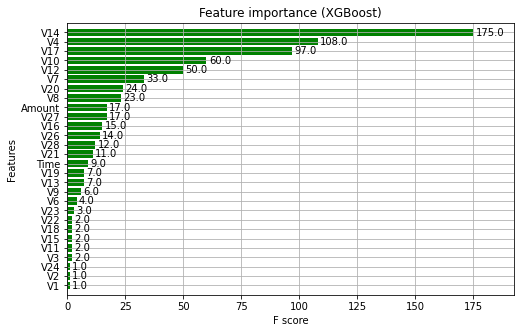

In [28]:
## feature importance with xgboost
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Feature importance (XGBoost)", ax=ax, color="green")
plt.show()

In [29]:
## preds on test set
preds = model.predict(dtest)

## roc-auc
roc_auc_score(test_df[target].values, preds)

0.9756353448680077

## Optimize hyperparameters

In [30]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

In [31]:
## define objective
class Objective(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __call__(self, trial):
        X = self.X.copy(deep=True)

        num_cols = X.select_dtypes(include = ['int64', 'float64']).columns
        cat_cols = X.select_dtypes(include = ['object', 'bool', 'category']).columns
        
        max_depth = trial.suggest_int('max_depth', 2, 64)
        n_estimators = trial.suggest_int('n_estimators', 20, 1200)
        learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3, step=0.001)
        gamma = trial.suggest_float('gamma', 0, 20)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 100)
        subsample = trial.suggest_float('subsample', 0.3, 1, step=0.01)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 1, step=0.01)
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.3, 1, step=0.01)
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.3, 1, step=0.01)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 6, step=0.01)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 6, step=0.01)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 1.2, step=0.01)

        gbm = xgb.XGBClassifier(
            objective='binary:logistic',
            n_jobs=2,
            eval_metric='logloss',
            use_label_encoder=False,
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            colsample_bynode=colsample_bynode,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            scale_pos_weight=scale_pos_weight
        )

        num_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='median'))
            ]
        )
        cat_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='constant', fill_value='nan')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]
        )
        preprocessor = ColumnTransformer(
            [
                ('numerical', num_pipeline, num_cols),
                ('categorical', cat_pipeline, cat_cols),
            ],
            remainder='passthrough'
        )

        prep_pipe = Pipeline(
            [
                ('trans', preprocessor)
            ]
        )

        pipe = Pipeline(
            [
                ('trans', preprocessor),
                ('clf', gbm)
            ]
        )

        skf = StratifiedKFold(n_splits=8, random_state=0, shuffle=True)
        oof_preds = cross_val_predict(
            pipe,
            X,
            self.y,
            cv=skf,
            method='predict_proba',
            n_jobs=-2
        )[:, 1]

        return roc_auc_score(self.y, oof_preds)

In [32]:
load_existing_study = False

if load_existing_study:
    study_name = "optuna_study_20221229"
else:
    date = str(datetime.now().date()).replace('-', '')
    study_name = f'optuna_study_{date}'
storage_name = f'sqlite:///{study_name}.db'

In [33]:
if load_existing_study:
    pass
else:
    n = 50
    objective = Objective(
        train_df[predictors],
        train_df[target].values
    )
    #sampler = optuna.samplers.TPESampler(multivariate=True)
    study = optuna.create_study(
        direction='maximize',
        study_name=study_name,
        storage=storage_name,
        load_if_exists=True
    )
    study.optimize(objective, n_trials=n)
    print("Training done")

[I 2023-02-13 19:37:56,252] A new study created in RDB with name: optuna_study_20230213
/Users/juandiegogallegoquiceno/.local/share/virtualenvs/ccFraud-bz6UI_fL/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/Users/juandiegogallegoquiceno/.local/share/virtualenvs/ccFraud-bz6UI_fL/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

[I 2023-02-13 19:38:22,295] Trial 0 finished with value: 0.9686227545984241 and parameters: {'max_depth': 22, 'n_estimators': 446, 'learning_rate': 0.20400000000000001, 'gamma': 15.100378776439907, 'min_child_weight': 51, 'subsample': 0.54, 'colsample_bytree': 0.45999999999999996, 'colsample_bylevel': 0.5800000000000001, 'colsample_bynode': 0.44999999999999996, 'reg_alpha': 5.32, 'reg_lambda': 3.0300000000000002, 'scale_pos_weight': 1.18}. Best is trial 0 with value: 0.9686227545984241.
/Users/juandiegogallegoquiceno/.local/share/virtua

KeyboardInterrupt: 